<div align="center">

# Использование "слабых учеников" в механизме адаптивного бустинга

</div>

---


## **AdaBoost**

### История и происхождение

* **Автор идеи**: Роберт Шапир (1990 г.).
* **Презентация алгоритма**: Роберт Шапир и Йоав Фройнд, ICML 1996 — статья *"Experiments with a New Boosting Algorithm"*.
* **Награда**: Премия Гёделя (2003 г.) за выдающийся вклад в компьютерные науки.

### Основная идея бустинга

* **Состав ансамбля**: множество **слабых учеников** (weak learners).
* **Пример слабого ученика**: обрубок дерева решений (decision stump).
* **Характеристика слабого ученика**: лишь немного лучше случайного угадывания.

### Принцип работы

* **Фокусировка на сложных примерах**: каждый новый классификатор обучается сильнее на тех данных, которые предыдущие классифицировали неправильно.
* **Эффект**: постепенное улучшение качества всего ансамбля.


## **Бустинг vs Бэггинг**

### 📌 Отличия от бэггинга

* **Бэггинг**: случайные подмножества **с возвращением** (bootstrap).
* **Первоначальный бустинг**: случайные подмножества **без замены**.
* **Цель**: акцент на сложных примерах, которые предыдущие модели классифицировали неверно.


## **Классическая схема первоначального бустинга**

1. **Шаг 1:** Обучить слабого ученика $C_1$ на случайной подвыборке $d_1$ (без замены) из $D$.
2. **Шаг 2:** Обучить $C_2$ на выборке $d_2$ + 50% неправильно классифицированных примеров.
3. **Шаг 3:** Найти примеры $d_3$, по которым $C_1$ и $C_2$ расходятся, и обучить $C_3$.
4. **Шаг 4:** Объединить $C_1, C_2, C_3$ через **мажоритарное голосование**.


## **Сильные и слабые стороны**

* 🔼 **Плюсы**: уменьшает систематическую ошибку и дисперсию (по Лео Брейману).
* 🔽 **Минусы**: склонен к высокой дисперсии (риск переобучения), особенно в AdaBoost.

## **Особенности AdaBoost**

* Использует **полный набор данных** на каждом шаге.
* Примеры **перевзвешиваются** после каждой итерации.
* Фокус на ошибках предыдущих классификаторов.
* Итоговый прогноз — **взвешенное голосование** слабых учеников.


## **Псевдокод AdaBoost**

### Инициализация

* Присвоить всем весам $w_i = \frac{1}{N}$, где $N$ — число примеров.

### Цикл (t раундов)

1. **Обучение**: $C_t = train(X, y, w)$ — слабый ученик с весами.
2. **Предсказание**: $\hat{y} = predict(C_t, X)$.
3. **Ошибка**: $e_t = w \cdot ( \hat{y} \neq y)$.
4. **Коэффициент**: $\alpha_t = 0.5 \log\frac{1-e_t}{e_t}$.
5. **Обновление весов**:
   $w := w \times \exp(-\alpha_t \times y \times \hat{y})$.
6. **Нормализация**: $w := \frac{w}{\sum w}$.

### Финальный прогноз

$$
y_{\text{final}} = \text{sign}\left(\sum_{t=1}^{T} \alpha_t \times predict(C_t, X)\right)
$$



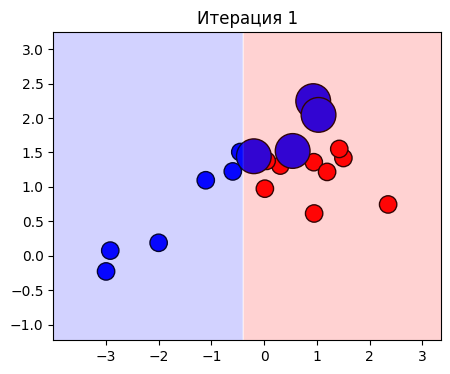

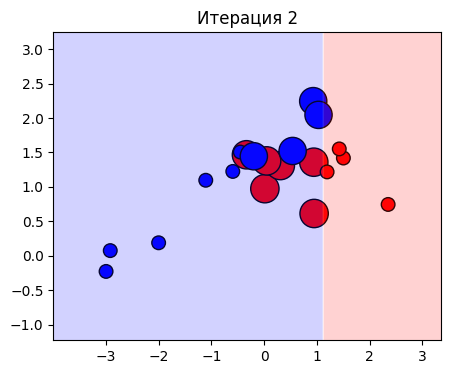

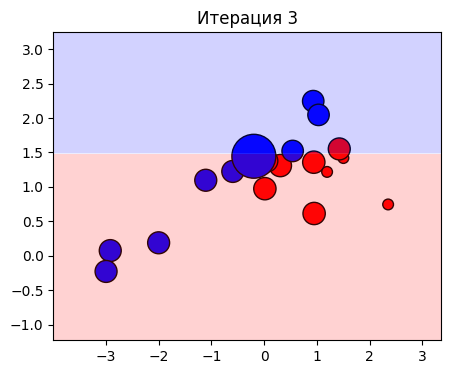

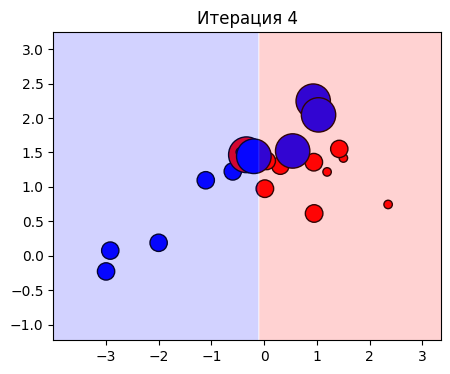

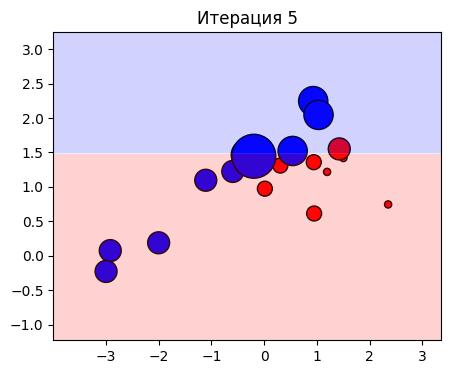

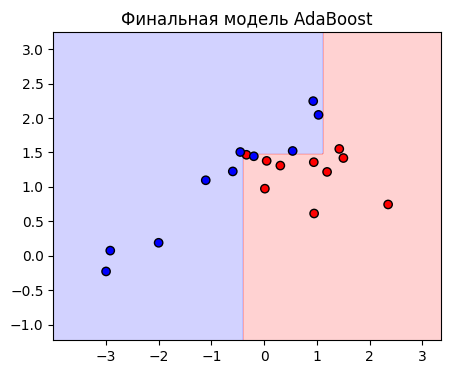

In [5]:
# Визуализация работы AdaBoost 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Генерация данных
X, y = make_classification(
    n_samples=20, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, flip_y=0, random_state=42
)
y = np.where(y == 0, -1, 1)  # для совместимости с формулами

# Параметры
T = 5  # количество итераций
clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=T
)
clf.fit(X, y)

# Получаем веса после каждой итерации
sample_weights = np.ones(len(X)) / len(X)
estimators = []
alphas = []

for t in range(T):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X, y, sample_weight=sample_weights)
    y_pred = stump.predict(X)

    err = np.sum(sample_weights * (y_pred != y))
    alpha = 0.5 * np.log((1 - err) / err)

    # Обновляем веса
    sample_weights *= np.exp(-alpha * y * y_pred)
    sample_weights /= sample_weights.sum()

    estimators.append(stump)
    alphas.append(alpha)

    # Визуализация на этом шаге
    plt.figure(figsize=(5, 4))
    plt.title(f"Итерация {t+1}")
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=sample_weights * 5000, edgecolors='k')
    
    # Рисуем границу решения
    xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
                         np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200))
    Z = stump.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.2, cmap='bwr')
    plt.show()

# Итоговая граница ансамбля
plt.figure(figsize=(5, 4))
plt.title("Финальная модель AdaBoost")
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
                     np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap='bwr')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')
plt.show()


In [11]:
# Применение AdaBoost на наборе данных Wine
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [12]:
# Загрузка данных
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/'
                      'wine/wine.data',
                      header = None)
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']

# Отбрасываем класс 1
df_wine = df_wine[df_wine['Class label'] != 1]

# Разделение данных
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values
y = df_wine['Class label'].values

df_wine[['Class label', 'Alcohol', 'OD280/OD315 of diluted wines']].head()

# Кодирование меток класса в двоичный формат
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size = 0.2,
                     random_state = 1,
                     stratify = y)

In [26]:
# Классификатор будет обучен на 500 обрубках дерева решений
tree = DecisionTreeClassifier(criterion = 'entropy',
                              random_state = 1,
                              max_depth = 1)

ada = AdaBoostClassifier(estimator = tree,
                         n_estimators = 500,
                         learning_rate = 1.0,
                         random_state = 1)
# Обучаем обрубок дерева решений
tree = tree.fit(X_train, y_train)
# Считаем точность
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Точность решающего дерева при обучении проверке '
      f'{tree_train:.3f} / {tree_test:.3f}')

Точность решающего дерева при обучении проверке 0.916 / 0.875


Очевидно, что обрубок дерева решений не полностью обучился на имеющихся обучающих данных.

In [27]:
# Обучение AdaBoost
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print(f'Точность AdaBoost при обучении и проверке '
      f'{ada_train:.3f} / {ada_test:.3f}')

Точность AdaBoost при обучении и проверке 1.000 / 0.917


Модель `AdaBoost` правильно предсказыает все метки классов обучающего набора данных, а также демонстрирует небольшое увелечение точности на тестовом наборе данных по сравнению с обрубком дерева решений. Но выбирать модель на основе одного и того же тестового набора данных - плохая практика, так как оценка обобщающей способности модели может оказаться чрезмерно оптимистичной. 

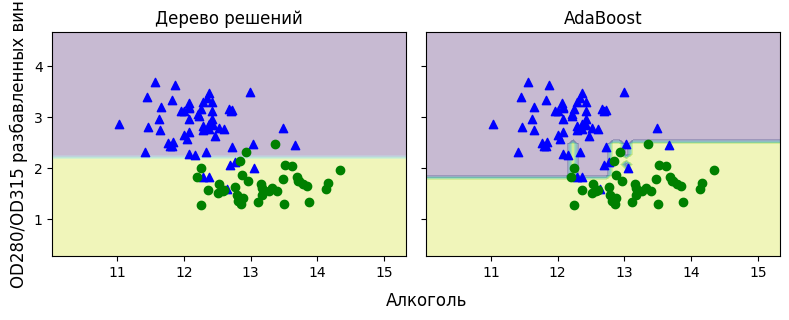

In [29]:
# Визуализация области принятия решений
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex = 'col',
                        sharey = 'row',
                        figsize = (8, 3))

for idx, clf, tt, in zip([0, 1],
                         [tree, ada],
                         ['Дерево решений', 'AdaBoost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha = 0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c = 'blue',
                       marker = '^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c = 'green',
                       marker = 'o')
    axarr[idx].set_title(tt)
    axarr[0].set_ylabel('OD280/OD315 разбавленных вин', fontsize = 12)
plt.tight_layout()
plt.text(0 , -0.2,
         s = 'Алкоголь',
         ha = 'center',
         va = 'center', 
         fontsize = 12,
         transform = axarr[1].transAxes)
plt.show()

На рисунке заметно, что разделяющая граница сложнее у `AdaBoost`, чем у обрубка дерева решений. Кроме того, модель `AdaBoost` похожа на модель `Badding` по разделению пространства функций.

---


### **Ансамблевые методы: вычислительная сложность**

#### Ключевой вывод

* Обучение ансамбля **требует больше вычислительных ресурсов**, чем обучение одного классификатора.
* Перед применением ансамблей стоит оценить **компромисс**:
  *Насколько оправдано увеличение затрат при относительно скромном росте точности?*


#### Пример из практики — Netflix Prize

* **Суть конкурса**: улучшить алгоритм рекомендаций Netflix.
* **Приз**: \$1 млн.
* **Победители**: использовали сложный ансамблевый метод.
* **Итог**: модель **не внедрена в продакшен** — прирост точности не окупил:

  * вычислительные затраты,
  * сложности интеграции,
  * эксплуатационные риски.


  **Практический урок**:
Даже если ансамбль даёт прирост точности, **стоимость его внедрения** и обслуживания может быть выше пользы. В продакшене часто выбирают **простые и быстрые модели** с чуть меньшей точностью, но высокой стабильностью и масштабируемостью.